# Import

In [1]:
import os
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"
# Machine Learning and Data Science Imports
import tensorflow as tf; print(f"\t\t– TENSORFLOW VERSION: {tf.__version__}");
import tensorflow_hub as tfhub; print(f"\t\t– TENSORFLOW HUB VERSION: {tfhub.__version__}");
import pandas as pd; pd.options.mode.chained_assignment = None;
import numpy as np; print(f"\t\t– NUMPY VERSION: {np.__version__}");
import sklearn; print(f"\t\t– SKLEARN VERSION: {sklearn.__version__}");
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.model_selection import GroupKFold, StratifiedKFold
# Built In Imports
from collections import Counter
from datetime import datetime
from glob import glob
import warnings
import requests
import hashlib
import imageio
import IPython
import sklearn
import urllib
import zipfile
import pickle
import random
import shutil
import string
import json
import math
import time
import gzip
import ast
import sys
import io
import os
import gc
import re

# Visualization Imports
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm; tqdm.pandas();
import plotly.express as px
import seaborn as sns
from PIL import Image, ImageEnhance
import matplotlib; print(f"\t\t– MATPLOTLIB VERSION: {matplotlib.__version__}");
from matplotlib import animation, rc; rc('animation', html='jshtml')
import plotly
import PIL
import cv2

import plotly.io as pio
print(pio.renderers)

def seed_it_all(seed=91):
    """ Attempt to be Reproducible """
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_it_all()

		– TENSORFLOW VERSION: 2.9.1
		– TENSORFLOW HUB VERSION: 0.12.0
		– NUMPY VERSION: 1.21.6
		– SKLEARN VERSION: 0.24.2
		– MATPLOTLIB VERSION: 3.5.0
Renderers configuration
-----------------------
    Default renderer: 'plotly_mimetype+notebook'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']



# Define data directory

In [2]:
DATA_DIR = "../data"
for file in glob(os.path.join(DATA_DIR, "*")):
    print(f"\t--> {file}")

	--> ../data\description.jpg
	--> ../data\model
	--> ../data\multiclass
	--> ../data\sample_submission.csv
	--> ../data\train
	--> ../data\train.csv
	--> ../data\train_df.pkl


# Read data

In [3]:
# Open the training dataframe and display the initial dataframe
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")
train_df = pd.read_csv(TRAIN_CSV)

# Get all training images
all_train_images = glob(os.path.join(TRAIN_DIR, "**", "*.png"), recursive=True)

print("\n... ORIGINAL TRAINING DATAFRAME... \n")
display(train_df)

TEST_DIR = os.path.join(DATA_DIR, "test")
SS_CSV   = os.path.join(DATA_DIR, "sample_submission.csv")
ss_df = pd.read_csv(SS_CSV)

# Get all testing images if there are any
all_test_images = glob(os.path.join(TEST_DIR, "**", "*.png"), recursive=True)

print("\n\n\n... ORIGINAL SUBMISSION DATAFRAME... \n")
display(ss_df)

# For debugging purposes when the test set hasn't been substituted we will know
DEBUG = len(all_test_images)==0

case_reg = re.compile(r"case\d{1,3}")

if DEBUG:
    TEST_DIR = TRAIN_DIR
    all_test_images = all_train_images
    
    cases = train_df["id"].map(lambda x:case_reg.search(x).group())
    using_case = random.sample(cases.unique().tolist(), 50)
    ss_df = train_df[cases.isin(using_case)]
    ss_df = ss_df[["id", "class"]]
    ss_df["predicted"] = ""
    
    print("\n\n\n... DEBUG SUBMISSION DATAFRAME... \n")
    display(ss_df)

classes = train_df["class"].unique().tolist()

print(f"\n\n\n... ARE WE DEBUGGING: {DEBUG}... \n")

print("\n... BASIC DATA SETUP FINISHED ...\n\n")


... ORIGINAL TRAINING DATAFRAME... 



id        class segmentation
0       case123_day20_slice_0001  large_bowel          NaN
1       case123_day20_slice_0001  small_bowel          NaN
2       case123_day20_slice_0001      stomach          NaN
3       case123_day20_slice_0002  large_bowel          NaN
4       case123_day20_slice_0002  small_bowel          NaN
...                          ...          ...          ...
115483    case30_day0_slice_0143  small_bowel          NaN
115484    case30_day0_slice_0143      stomach          NaN
115485    case30_day0_slice_0144  large_bowel          NaN
115486    case30_day0_slice_0144  small_bowel          NaN
115487    case30_day0_slice_0144      stomach          NaN

[115488 rows x 3 columns]




... ORIGINAL SUBMISSION DATAFRAME... 



Empty DataFrame
Columns: [id, class, predicted]
Index: []




... DEBUG SUBMISSION DATAFRAME... 



id        class predicted
2592    case133_day0_slice_0001  large_bowel          
2593    case133_day0_slice_0001  small_bowel          
2594    case133_day0_slice_0001      stomach          
2595    case133_day0_slice_0002  large_bowel          
2596    case133_day0_slice_0002  small_bowel          
...                         ...          ...       ...
112459    case2_day4_slice_0143  small_bowel          
112460    case2_day4_slice_0143      stomach          
112461    case2_day4_slice_0144  large_bowel          
112462    case2_day4_slice_0144  small_bowel          
112463    case2_day4_slice_0144      stomach          

[70368 rows x 3 columns]




... ARE WE DEBUGGING: True... 


... BASIC DATA SETUP FINISHED ...




# DF preprocessing

In [11]:
reg_extract_id = re.compile(r"case(?P<case>\d{1,3})_day(?P<day>\d{1,})_slice_(?P<slice>\d{1,})")
reg_extract_path = re.compile(r"case(?P<case>\d{1,3})_day(?P<day>\d{1,}).*slice_(?P<slice>\d{1,})_(?P<height>\d{1,})_(?P<width>\d{1,})_(?P<height_pixel>\d{1,}.\d{1,})_(?P<width_pixel>\d{1,}.\d{1,})")

def df_preprocessing(df, globbed_file_list, is_test=False):
    df["case_id"] = df["id"].map(lambda x:int(reg_extract_id.search(x).group("case")))
    df["case_id_str"] = df["id"].map(lambda x: "case" + reg_extract_id.search(x).group("case"))
    df["day_num"] = df["id"].map(lambda x:int(reg_extract_id.search(x).group("day")))
    df["day_num_str"] = df["id"].map(lambda x: "day" + reg_extract_id.search(x).group("day"))
    df["slice_id"] = df["id"].map(lambda x: "slice_" + reg_extract_id.search(x).group("slice"))
    def get_partial_ident(f_path):
        searched = reg_extract_path.search(f_path)
        case_id = "case" + searched.group("case")
        day_num = "day" + searched.group("day")
        slice_id = "slice_" + searched.group("slice")
        return f"{case_id}_{day_num}_{slice_id}"

    df["_partial_ident"] = df["case_id_str"] + "_" + df["day_num_str"] + "_" + df["slice_id"]
    
    _tmp_merge_df = pd.DataFrame(
        {
            "_partial_ident":[get_partial_ident(f_path) for f_path in globbed_file_list],
            "f_path":globbed_file_list
        }
    )
    
    df = df.merge(_tmp_merge_df, on="_partial_ident").drop(columns=["_partial_ident"])
    
    df["slice_h"] = df["f_path"].map(lambda x:int(reg_extract_path.search(x).group("height")))
    df["slice_w"] = df["f_path"].map(lambda x:int(reg_extract_path.search(x).group("width")))
    df["px_spacing_h"] = df["f_path"].map(lambda x:float(reg_extract_path.search(x).group("height_pixel")))
    df["px_spacing_w"] = df["f_path"].map(lambda x:float(reg_extract_path.search(x).group("width_pixel")))
    
    if not is_test:
        # 7. Merge 3 Rows Into A Single Row (As This/Segmentation-RLE Is The Only Unique Information Across Those Rows)
        l_bowel_df = df[df["class"]=="large_bowel"][["id", "segmentation"]].rename(columns={"segmentation":"lb_seg_rle"})
        s_bowel_df = df[df["class"]=="small_bowel"][["id", "segmentation"]].rename(columns={"segmentation":"sb_seg_rle"})
        stomach_df = df[df["class"]=="stomach"][["id", "segmentation"]].rename(columns={"segmentation":"st_seg_rle"})
        df = df.merge(l_bowel_df, on="id", how="left")
        df = df.merge(s_bowel_df, on="id", how="left")
        df = df.merge(stomach_df, on="id", how="left")
        df = df.drop_duplicates(subset=["id",]).reset_index(drop=True)
        df["lb_seg_flag"] = df["lb_seg_rle"].apply(lambda x: not pd.isna(x))
        df["sb_seg_flag"] = df["sb_seg_rle"].apply(lambda x: not pd.isna(x))
        df["st_seg_flag"] = df["st_seg_rle"].apply(lambda x: not pd.isna(x))
        df["n_segs"] = df["lb_seg_flag"].astype(int)+df["sb_seg_flag"].astype(int)+df["st_seg_flag"].astype(int)
        new_col_order = ["id", "f_path", "n_segs",
                         "lb_seg_rle", "lb_seg_flag",
                         "sb_seg_rle", "sb_seg_flag", 
                         "st_seg_rle", "st_seg_flag",
                         "slice_h", "slice_w", "px_spacing_h", 
                         "px_spacing_w", "case_id_str", "case_id", 
                         "day_num_str", "day_num", "slice_id", "predicted"]
        if is_test: new_col_order.insert(1, "class")
        new_col_order = [_c for _c in new_col_order if _c in df.columns]
        df = df[new_col_order]
    return df

In [12]:
print("\n... UPDATING DATAFRAMES WITH ACCESSIBLE INFORMATION STARTED ...\n\n")

print("\n... UPDATED TRAINING DATAFRAME... \n")
train_df = df_preprocessing(train_df, all_train_images)
display(train_df)

ss_df = df_preprocessing(ss_df, all_test_images, is_test=True)
print("\n\n\n... UPDATED SUBMISSION DATAFRAME... \n")
display(ss_df)

print("\n... UPDATING DATAFRAMES WITH ACCESSIBLE INFORMATION FINISHED ...\n\n")


... UPDATING DATAFRAMES WITH ACCESSIBLE INFORMATION STARTED ...



... UPDATED TRAINING DATAFRAME... 



id  \
0      case123_day20_slice_0001   
1      case123_day20_slice_0002   
2      case123_day20_slice_0003   
3      case123_day20_slice_0004   
4      case123_day20_slice_0005   
...                         ...   
38491    case30_day0_slice_0140   
38492    case30_day0_slice_0141   
38493    case30_day0_slice_0142   
38494    case30_day0_slice_0143   
38495    case30_day0_slice_0144   

                                                  f_path  n_segs lb_seg_rle  \
0      ../data\train\case123\case123_day20\scans\slic...       0        NaN   
1      ../data\train\case123\case123_day20\scans\slic...       0        NaN   
2      ../data\train\case123\case123_day20\scans\slic...       0        NaN   
3      ../data\train\case123\case123_day20\scans\slic...       0        NaN   
4      ../data\train\case123\case123_day20\scans\slic...       0        NaN   
...                                                  ...     ...        ...   
38491  ../data\train\case30\case30_day0\scans\slice_0...       0        NaN   
38492  ../data\train\case30\case30_day0\scans\slice_0...       0        NaN   
38493  ../data\train\case30\case30_day0\scans\slice_0...       0        NaN   
38494  ../data\train\case30\case30_day0\scans\slice_0...       0        NaN   
38495  ../data\train\case30\case30_day0\scans\slice_0...       0        NaN   

       lb_seg_flag sb_seg_rle  sb_seg_flag st_seg_rle  st_seg_flag  slice_h  \
0            False        NaN        False        NaN        False      266   
1            False        NaN        False        NaN        False      266   
2            False        NaN        False        NaN        False      266   
3            False        NaN        False        NaN        False      266   
4            False        NaN        False        NaN        False      266   
...            ...        ...          ...        ...          ...      ...   
38491        False        NaN        False        NaN        False      266   
38492        False        NaN        False        NaN        False      266   
38493        False        NaN        False        NaN        False      266   
38494        False        NaN        False        NaN        False      266   
38495        False        NaN        False        NaN        False      266   

       slice_w  px_spacing_h  px_spacing_w case_id_str  case_id day_num_str  \
0          266           1.5           1.5     case123      123       day20   
1          266           1.5           1.5     case123      123       day20   
2          266           1.5           1.5     case123      123       day20   
3          266           1.5           1.5     case123      123       day20   
4          266           1.5           1.5     case123      123       day20   
...        ...           ...           ...         ...      ...         ...   
38491      266           1.5           1.5      case30       30        day0   
38492      266           1.5           1.5      case30       30        day0   
38493      266           1.5           1.5      case30       30        day0   
38494      266           1.5           1.5      case30       30        day0   
38495      266           1.5           1.5      case30       30        day0   

       day_num    slice_id  
0           20  slice_0001  
1           20  slice_0002  
2           20  slice_0003  
3           20  slice_0004  
4           20  slice_0005  
...        ...         ...  
38491        0  slice_0140  
38492        0  slice_0141  
38493        0  slice_0142  
38494        0  slice_0143  
38495        0  slice_0144  

[38496 rows x 18 columns]




... UPDATED SUBMISSION DATAFRAME... 



id        class predicted  case_id case_id_str  \
0      case133_day0_slice_0001  large_bowel                133     case133   
1      case133_day0_slice_0001  small_bowel                133     case133   
2      case133_day0_slice_0001      stomach                133     case133   
3      case133_day0_slice_0002  large_bowel                133     case133   
4      case133_day0_slice_0002  small_bowel                133     case133   
...                        ...          ...       ...      ...         ...   
70363    case2_day4_slice_0143  small_bowel                  2       case2   
70364    case2_day4_slice_0143      stomach                  2       case2   
70365    case2_day4_slice_0144  large_bowel                  2       case2   
70366    case2_day4_slice_0144  small_bowel                  2       case2   
70367    case2_day4_slice_0144      stomach                  2       case2   

       day_num day_num_str    slice_id  \
0            0        day0  slice_0001   
1            0        day0  slice_0001   
2            0        day0  slice_0001   
3            0        day0  slice_0002   
4            0        day0  slice_0002   
...        ...         ...         ...   
70363        4        day4  slice_0143   
70364        4        day4  slice_0143   
70365        4        day4  slice_0144   
70366        4        day4  slice_0144   
70367        4        day4  slice_0144   

                                                  f_path  slice_h  slice_w  \
0      ../data\train\case133\case133_day0\scans\slice...      360      310   
1      ../data\train\case133\case133_day0\scans\slice...      360      310   
2      ../data\train\case133\case133_day0\scans\slice...      360      310   
3      ../data\train\case133\case133_day0\scans\slice...      360      310   
4      ../data\train\case133\case133_day0\scans\slice...      360      310   
...                                                  ...      ...      ...   
70363  ../data\train\case2\case2_day4\scans\slice_014...      266      266   
70364  ../data\train\case2\case2_day4\scans\slice_014...      266      266   
70365  ../data\train\case2\case2_day4\scans\slice_014...      266      266   
70366  ../data\train\case2\case2_day4\scans\slice_014...      266      266   
70367  ../data\train\case2\case2_day4\scans\slice_014...      266      266   

       px_spacing_h  px_spacing_w  
0               1.5           1.5  
1               1.5           1.5  
2               1.5           1.5  
3               1.5           1.5  
4               1.5           1.5  
...             ...           ...  
70363           1.5           1.5  
70364           1.5           1.5  
70365           1.5           1.5  
70366           1.5           1.5  
70367           1.5           1.5  

[70368 rows x 13 columns]


... UPDATING DATAFRAMES WITH ACCESSIBLE INFORMATION FINISHED ...




# Define help functions

In [13]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
# modified from: https://www.kaggle.com/inversion/run-length-decoding-quick-start
def rle_decode(mask_rle, shape, color=1):
    """ TBD
    
    Args:
        mask_rle (str): run-length as string formated (start length)
        shape (tuple of ints): (height,width) of array to return 
    
    Returns: 
        Mask (np.array)
            - 1 indicating mask
            - 0 indicating background

    """
    # Split the string by space, then convert it into a integer array
    s = np.array(mask_rle.split(), dtype=int)

    # Every even value is the start, every odd value is the "run" length
    starts = s[0::2] - 1
    lengths = s[1::2]
    ends = starts + lengths

    # The image image is actually flattened since RLE is a 1D "run"
    if len(shape)==3:
        h, w, d = shape
        img = np.zeros((h * w, d), dtype=np.float32)
    else:
        h, w = shape
        img = np.zeros((h * w,), dtype=np.float32)

    # The color here is actually just any integer you want!
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
        
    # Don't forget to change the image back to the original shape
    return img.reshape(shape)

# https://www.kaggle.com/namgalielei/which-reshape-is-used-in-rle
def rle_decode_top_to_bot_first(mask_rle, shape):
    """ TBD
    
    Args:
        mask_rle (str): run-length as string formated (start length)
        shape (tuple of ints): (height,width) of array to return 
    
    Returns:
        Mask (np.array)
            - 1 indicating mask
            - 0 indicating background

    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape((shape[1], shape[0]), order='F').T  # Reshape from top -> bottom first

# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    """ TBD
    
    Args:
        img (np.array): 
            - 1 indicating mask
            - 0 indicating background
    
    Returns: 
        run length as string formated
    """
    
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def flatten_l_o_l(nested_list):
    """ Flatten a list of lists """
    return [item for sublist in nested_list for item in sublist]

def load_json_to_dict(json_path):
    """ tbd """
    with open(json_path) as json_file:
        data = json.load(json_file)
    return data

def tf_load_png(img_path):
    return tf.image.decode_png(tf.io.read_file(img_path), channels=3)

def open_gray16(_path, normalize=True, to_rgb=False):
    """ Helper to open files """
    if normalize:
        if to_rgb:
            return np.tile(np.expand_dims(cv2.imread(_path, cv2.IMREAD_ANYDEPTH)/65535., axis=-1), 3)
        else:
            return cv2.imread(_path, cv2.IMREAD_ANYDEPTH)/65535.
    else:
        if to_rgb:
            return np.tile(np.expand_dims(cv2.imread(_path, cv2.IMREAD_ANYDEPTH), axis=-1), 3)
        else:
            return cv2.imread(_path, cv2.IMREAD_ANYDEPTH)
        
def rle_decode_tf(mask_rle, shape):
    """ TBD """
    
    shape = tf.convert_to_tensor(shape, tf.int64)
    size = tf.math.reduce_prod(shape)
    
    # Split string
    s = tf.strings.split(mask_rle)
    s = tf.strings.to_number(s, tf.int64)
    
    # Get starts and lengths
    starts = s[::2] - 1
    lens = s[1::2]
    
    # Make ones to be scattered
    total_ones = tf.reduce_sum(lens)
    ones = tf.ones([total_ones], tf.uint8)
    
    # Make scattering indices
    r = tf.range(total_ones)
    lens_cum = tf.math.cumsum(lens)
    s = tf.searchsorted(lens_cum, r, 'right')
    idx = r + tf.gather(starts - tf.pad(lens_cum[:-1], [(1, 0)]), s)
    
    # Scatter ones into flattened mask
    mask_flat = tf.scatter_nd(tf.expand_dims(idx, 1), ones, [size])
    
    # Reshape into mask
    return tf.reshape(mask_flat, shape)

# Group Folding

In [14]:
if DEBUG:
    N_FOLDS = 8
    gkf = GroupKFold(n_splits=N_FOLDS) 
    train_df["which_segs"] = train_df["lb_seg_flag"].astype(int).astype(str)+\
                             train_df["sb_seg_flag"].astype(int).astype(str)+\
                             train_df["st_seg_flag"].astype(int).astype(str)

    for train_idxs, val_idxs in gkf.split(train_df["id"], train_df["which_segs"], train_df["case_id"]):
        sub_train_df = train_df.iloc[train_idxs]
        N_TRAIN = len(sub_train_df)
        sub_train_df = sub_train_df.sample(N_TRAIN).reset_index(drop=True)

        sub_val_df = train_df.iloc[val_idxs]
        N_VAL = len(sub_val_df)
        sub_val_df = sub_val_df.sample(N_VAL).reset_index(drop=True)
        break

    # Fix the way we handled nan
    sub_train_df.lb_seg_rle.fillna("", inplace=True)
    sub_train_df.sb_seg_rle.fillna("", inplace=True)
    sub_train_df.st_seg_rle.fillna("", inplace=True)
    
    # Fix the way we handled nan
    sub_val_df.lb_seg_rle.fillna("", inplace=True)
    sub_val_df.sb_seg_rle.fillna("", inplace=True)
    sub_val_df.st_seg_rle.fillna("", inplace=True)

    print("\nFOLD 1: TRAIN DF\n\n")
    display(sub_train_df)

    print("\n\n\n\nFOLD 1: VAL DF\n\n")
    display(sub_val_df)


FOLD 1: TRAIN DF




id  \
0        case33_day0_slice_0057   
1      case134_day21_slice_0083   
2        case74_day0_slice_0077   
3       case20_day24_slice_0016   
4      case142_day16_slice_0075   
...                         ...   
33659  case154_day13_slice_0086   
33660   case43_day18_slice_0101   
33661    case29_day0_slice_0142   
33662    case74_day0_slice_0035   
33663  case139_day18_slice_0127   

                                                  f_path  n_segs  \
0      ../data\train\case33\case33_day0\scans\slice_0...       0   
1      ../data\train\case134\case134_day21\scans\slic...       2   
2      ../data\train\case74\case74_day0\scans\slice_0...       1   
3      ../data\train\case20\case20_day24\scans\slice_...       0   
4      ../data\train\case142\case142_day16\scans\slic...       2   
...                                                  ...     ...   
33659  ../data\train\case154\case154_day13\scans\slic...       2   
33660  ../data\train\case43\case43_day18\scans\slice_...       2   
33661  ../data\train\case29\case29_day0\scans\slice_0...       0   
33662  ../data\train\case74\case74_day0\scans\slice_0...       0   
33663  ../data\train\case139\case139_day18\scans\slic...       0   

                                              lb_seg_rle  lb_seg_flag  \
0                                                               False   
1      33985 13 34343 18 34377 19 34702 30 34734 24 3...         True   
2                                                               False   
3                                                               False   
4      18960 15 19224 18 19489 20 19753 23 20018 24 2...         True   
...                                                  ...          ...   
33659  18177 11 18439 16 18697 25 18960 28 19225 29 1...         True   
33660  28631 3 28895 9 29160 13 29174 3 29425 20 2969...         True   
33661                                                           False   
33662                                                           False   
33663                                                           False   

                                              sb_seg_rle  sb_seg_flag  \
0                                                               False   
1      41606 8 41965 10 42324 12 42684 13 43044 14 43...         True   
2                                                               False   
3                                                               False   
4      18500 3 18764 9 19029 12 19294 17 19559 22 198...         True   
...                                                  ...          ...   
33659  22506 9 22770 14 23035 18 23300 21 23565 25 23...         True   
33660  25942 5 26205 9 26469 12 26734 14 26998 17 272...         True   
33661                                                           False   
33662                                                           False   
33663                                                           False   

                                              st_seg_rle  st_seg_flag  \
0                                                               False   
1                                                               False   
2      27829 4 28090 10 28355 12 28620 14 28885 16 29...         True   
3                                                               False   
4                                                               False   
...                                                  ...          ...   
33659                                                           False   
33660                                                           False   
33661                                                           False   
33662                                                           False   
33663                                                           False   

       slice_h  slice_w  px_spacing_h  px_spacing_w case_id_str  case_id  \
0          266      266           1.5           1.5      case33       33   
1       





FOLD 1: VAL DF




id  \
0       case36_day6_slice_0067   
1       case36_day6_slice_0121   
2       case41_day0_slice_0123   
3     case133_day23_slice_0001   
4      case18_day25_slice_0118   
...                        ...   
4827   case18_day21_slice_0006   
4828  case130_day20_slice_0034   
4829   case36_day10_slice_0012   
4830    case36_day8_slice_0078   
4831   case41_day32_slice_0091   

                                                 f_path  n_segs  \
0     ../data\train\case36\case36_day6\scans\slice_0...       2   
1     ../data\train\case36\case36_day6\scans\slice_0...       0   
2     ../data\train\case41\case41_day0\scans\slice_0...       0   
3     ../data\train\case133\case133_day23\scans\slic...       0   
4     ../data\train\case18\case18_day25\scans\slice_...       0   
...                                                 ...     ...   
4827  ../data\train\case18\case18_day21\scans\slice_...       0   
4828  ../data\train\case130\case130_day20\scans\slic...       0   
4829  ../data\train\case36\case36_day10\scans\slice_...       0   
4830  ../data\train\case36\case36_day8\scans\slice_0...       2   
4831  ../data\train\case41\case41_day32\scans\slice_...       1   

                                             lb_seg_rle  lb_seg_flag  \
0     31604 8 31869 10 32134 12 32400 13 32666 13 32...         True   
1                                                              False   
2                                                              False   
3                                                              False   
4                                                              False   
...                                                 ...          ...   
4827                                                           False   
4828                                                           False   
4829                                                           False   
4830  18759 5 18770 5 19006 3 19024 7 19035 8 19270 ...         True   
4831                                                           False   

                                             sb_seg_rle  sb_seg_flag  \
0     23833 3 24096 8 24361 13 24627 15 24893 18 251...         True   
1                                                              False   
2                                                              False   
3                                                              False   
4                                                              False   
...                                                 ...          ...   
4827                                                           False   
4828                                                           False   
4829                                                           False   
4830  22222 5 22486 9 22751 12 23017 13 23282 15 235...         True   
4831                                                           False   

                                             st_seg_rle  st_seg_flag  slice_h  \
0                                                              False      266   
1                                                              False      266   
2                                                              False      360   
3                                                              False      360   
4                                                              False      360   
...                                                 ...          ...      ...   
4827                                                           False      360   
4828                                                           False      266   
4829                                                           False      266   
4830                                                           False      266   
4831  24148 10 24411 15 24675 18 24940 20 25205 22 2...         True      266   

      slice_w  px_spacing_h  px_spacing_w case_id_str  case_id day_num_str  \
0         266           1.5      

# Make mask data

In [15]:
IMAGE_SHAPE = SEG_SHAPE = (224,224)

def make_seg_mask(row, output_dir, resize_to):
    """"""
    _output_style = "multiclass" if "multiclass" in output_dir else "multilabel"
    _slice_shape = (row["slice_w"], row["slice_h"])
    
    if not pd.isna(row["lb_seg_rle"]):
        lb_mask = rle_decode(row["lb_seg_rle"], _slice_shape)
    else:
        lb_mask = np.zeros(_slice_shape)
        
    if not pd.isna(row["sb_seg_rle"]):
        sb_mask = rle_decode(row["sb_seg_rle"], _slice_shape)
    else:
        sb_mask = np.zeros(_slice_shape)
        
    if not pd.isna(row["st_seg_rle"]):
        st_mask = rle_decode(row["st_seg_rle"], _slice_shape)
    else:
        st_mask = np.zeros(_slice_shape)
    
    if _output_style == "multiclass":
        mask_arr = st_mask * 3                       # stomach     = 3
        mask_arr = np.where(sb_mask==1, 2, mask_arr) # small bowel = 2
        mask_arr = np.where(lb_mask==1, 1, mask_arr) # large bowel = 1
    else:
        mask_arr = np.stack([lb_mask, sb_mask, st_mask], axis=-1)
    
    mask_arr = cv2.resize(mask_arr, resize_to, interpolation=cv2.INTER_NEAREST).astype(np.uint8)
    mask_path = os.path.join(output_dir, f"{row.id}_mask")
    np.save(mask_path, mask_arr)
    return mask_path + ".npy"

STYLE = "multiclass"
if DEBUG: 
    _output_dir = f"{DATA_DIR}/{STYLE}/npy_files"
    if not os.path.isdir(_output_dir):
        os.makedirs(_output_dir, exist_ok=True)
    train_df[f"{STYLE}_mask_path"] = train_df.progress_apply(lambda _row: make_seg_mask(_row, _output_dir, resize_to=SEG_SHAPE), axis=1)
    sub_train_df = sub_train_df.merge(train_df[["id", f"{STYLE}_mask_path"]], on="id")
    sub_val_df = sub_val_df.merge(train_df[["id", f"{STYLE}_mask_path"]], on="id")

  0%|          | 0/38496 [00:00<?, ?it/s]

# Load image and mask

In [9]:
def tf_load_image(path):
    """ Load an image with the correct shape using only TF
    
    Args:
        path (tf.string): Path to the image to be loaded
        resize_to (tuple, optional): Size to reshape image
    
    Returns:
        3 channel tf.Constant image ready for training/inference
    
    """
    img_bytes = tf.io.read_file(path)
    img = tf.image.decode_png(img_bytes, channels=3, dtype=tf.uint16)
#     img = 255.*(img/tf.constant(32767, dtype=tf.uint16))
    img = 255.*(img/tf.reduce_max(img))
    img = tf.image.resize(img, (tf.constant(IMAGE_SHAPE[0]), tf.constant(IMAGE_SHAPE[1])))
    return img


def tf_load_mask(rle_strs, root_shape, style="multiclass"):
    """ TBD """
    tf_masks = [
        tf.cast(
            tf.image.resize(
                tf.expand_dims(
                    rle_decode_tf(
                        rle_str, root_shape
                    ), axis=-1
                ),
                size=(tf.constant(SEG_SHAPE[0]), tf.constant(SEG_SHAPE[1])),
                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
            ), tf.uint8
        ) for rle_str in rle_strs
    ]
    
    if style=="multilabel":
        return tf.concat(tf_masks, axis=-1)
    else:        
        _tf_masks = tf.zeros((*SEG_SHAPE, 1), dtype=tf.uint8)
        _tf_masks = tf_masks[2]*tf.constant(3, dtype=tf.uint8) # small bowel = 3
        _tf_masks = tf.where(tf_masks[1]==tf.constant(1, dtype=tf.uint8), tf.constant(2, dtype=tf.uint8), _tf_masks) # small bowel = 2
        _tf_masks = tf.where(tf_masks[0]==tf.constant(1, dtype=tf.uint8), tf.constant(1, dtype=tf.uint8), _tf_masks) # large bowel = 1
        return _tf_masks

def augment_batch(img_batch, mask_batch):
    
    # Simple augmentation
    #if tf.random.uniform([])<=tf.constant(0.5):
    #    img_batch = tf.image.flip_left_right(img_batch)
    #    mask_batch = tf.image.flip_left_right(mask_batch)
        
    return img_batch, mask_batch

def model_preprocessing_train(img_batch, mask_batch):
    img_batch = img_batch/tf.constant(127.5)-tf.constant(1.0)
    return img_batch, mask_batch
    
def model_preprocessing_test(img_batch):
    img_batch = img_batch/tf.constant(127.5)-tf.constant(1.0)
    return img_batch

# Set the hyper parameters

In [10]:
# Hyperparameters
BATCH_SIZE = 24
SHUFFLE_BUFFER = max(BATCH_SIZE * 25, 512)
AUTOTUNE = tf.data.AUTOTUNE

# Whether or not to train?
DO_TRAIN=True
if not DEBUG:
    DO_TRAIN=False

# Make data to dataset

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

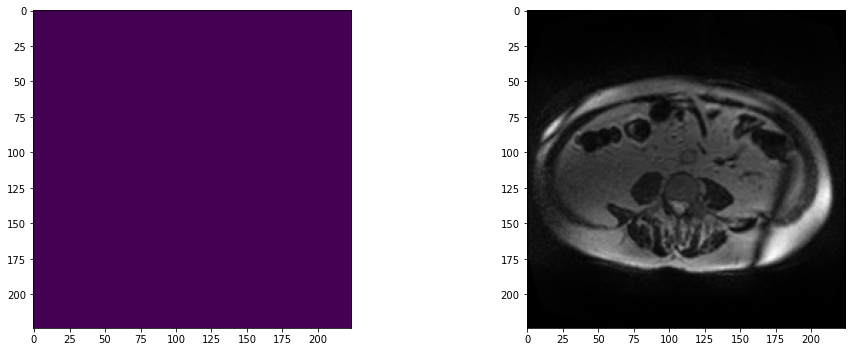

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

In [11]:
if DEBUG:
    train_ds = tf.data.Dataset.from_tensor_slices(
        (
            sub_train_df["f_path"],
            (sub_train_df["lb_seg_rle"], sub_train_df["sb_seg_rle"], sub_train_df["sb_seg_rle"]),
            (sub_train_df["slice_w"], sub_train_df["slice_h"])
        )
    )
    val_ds = tf.data.Dataset.from_tensor_slices(
        (
            sub_val_df["f_path"],
            (sub_val_df["lb_seg_rle"], sub_val_df["sb_seg_rle"], sub_val_df["sb_seg_rle"]),
            (sub_val_df["slice_w"], sub_val_df["slice_h"])
        )
    )

    train_ds = train_ds.map(lambda x,y,z: (tf_load_image(x), tf_load_mask(y,z,style=STYLE)), num_parallel_calls=AUTOTUNE)
    val_ds = val_ds.map(lambda x,y,z: (tf_load_image(x), tf_load_mask(y,z,style=STYLE)), num_parallel_calls=AUTOTUNE)

    train_ds = train_ds.shuffle(SHUFFLE_BUFFER)\
                       .batch(BATCH_SIZE, drop_remainder=True)\
                       .map(augment_batch, num_parallel_calls=AUTOTUNE)\
                       .map(model_preprocessing_train, num_parallel_calls=AUTOTUNE)\
                       .prefetch(AUTOTUNE)

    # we only shuffle the validation a little because we don't want 
    # drop_remainder to hit the same images over and over...
    val_ds = val_ds.shuffle(SHUFFLE_BUFFER//5)\
                   .batch(BATCH_SIZE, drop_remainder=True)\
                   .map(model_preprocessing_train, num_parallel_calls=AUTOTUNE)\
                   .prefetch(AUTOTUNE)
    
    for _img_batch, _mask_batch in train_ds.take(1):
        print(_img_batch.shape, _mask_batch.shape)
        _img=_img_batch[0]
        _mask=_mask_batch[0]
        plt.figure(figsize=(15,5))
        plt.subplot(1,2,1)
        plt.imshow(tf.cast(_mask, tf.float32))

        plt.subplot(1,2,2)
        plt.imshow(tf.cast((_img+1)*127.5, tf.uint8))

        plt.tight_layout()
        plt.show()
        
# We only need every third row (hence the iloc[::3])
test_ds = tf.data.Dataset.from_tensor_slices(ss_df.iloc[::3]["f_path"].tolist())
test_ds = test_ds.map(lambda x: tf_load_image(x), num_parallel_calls=AUTOTUNE)

# This should be deterministic... i.e. the order of images will match the order of IDs
test_ds = test_ds.batch(BATCH_SIZE)\
                 .map(model_preprocessing_test, num_parallel_calls=AUTOTUNE)\
                 .prefetch(AUTOTUNE)

# Stack the layers

In [12]:
def convolution_block(block_input, num_filters=256, kernel_size=3,
                      dilation_rate=1, padding="same", use_bias=False,):
    """ TBD """
    x = tf.keras.layers.Conv2D(filters=num_filters, 
                               kernel_size=kernel_size, 
                               dilation_rate=dilation_rate, 
                               padding=padding, 
                               use_bias=use_bias, 
                               kernel_initializer=tf.keras.initializers.HeNormal())(block_input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    return x

def DilatedSpatialPyramidPooling(dspp_input):
    """ TBD """
    x = tf.keras.layers.AveragePooling2D(pool_size=(HIGH_FEAT_LAYER_OUTPUT_SHAPE[-3], 
                                                    HIGH_FEAT_LAYER_OUTPUT_SHAPE[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    
    # Get layers to concatenate
    out_pool = tf.keras.layers.UpSampling2D(size=(HIGH_FEAT_LAYER_OUTPUT_SHAPE[-3]//x.shape[1], 
                                                  HIGH_FEAT_LAYER_OUTPUT_SHAPE[-2]//x.shape[2]), 
                                            interpolation="bilinear")(x)
    _out_layers = [out_pool,]+\
                  [convolution_block(dspp_input, 256, _k, _d) for _k, _d in zip((1,3,3,3), (1,6,12,18))]
    
    output = convolution_block(tf.keras.layers.Concatenate(axis=-1)(_out_layers), kernel_size=1)

    return output

def DeeplabV3Plus(backbone, low_feat_layer, high_feat_layer, n_classes, weights="imagenet", dropout=0.2):
    
    _inputs = tf.keras.layers.Input(shape=(*IMAGE_SHAPE, 3))
    encoder_bb = backbone(weights=weights, include_top=False, input_tensor=_inputs)
    
    x = encoder_bb.get_layer(high_feat_layer).output
    x = tf.keras.layers.Dropout(dropout)(x)
    x = DilatedSpatialPyramidPooling(x)
    
    input_a = tf.keras.layers.UpSampling2D(size=(IMAGE_SHAPE[0]//4//x.shape[1], 
                                                 IMAGE_SHAPE[1]//4//x.shape[2]), 
                                           interpolation="bilinear")(x)
    input_b = encoder_bb.get_layer(low_feat_layer).output
    input_b = tf.keras.layers.Dropout(dropout)(input_b)
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = tf.keras.layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = tf.keras.layers.UpSampling2D(size=(IMAGE_SHAPE[0]//x.shape[1], 
                                           IMAGE_SHAPE[1]//x.shape[2]), 
                                     interpolation="bilinear",)(x)
    x = tf.keras.layers.Dropout(dropout/2)(x)
    _outputs = tf.keras.layers.Conv2D(n_classes, kernel_size=(1, 1), padding="same")(x)
    return tf.keras.Model(inputs=_inputs, outputs=_outputs)


# If you change the backbone you will need to adjust this accordingly
BACKBONE = tf.keras.applications.ResNet50
RES_HIGH_FEAT_LAYER = "conv4_block6_2_relu"
RES_LOW_FEAT_LAYER = "conv2_block3_2_relu"
_dummy_model = BACKBONE(include_top=False, weights=None, input_shape=(*IMAGE_SHAPE, 3))
HIGH_FEAT_LAYER_OUTPUT_SHAPE = _dummy_model.get_layer(RES_HIGH_FEAT_LAYER).output_shape[1:]
LOW_FEAT_LAYER_OUTPUT_SHAPE = _dummy_model.get_layer(RES_LOW_FEAT_LAYER).output_shape[1:]

SUB_NODEBUG_MODEL_WT_PATH = f"{DATA_DIR}/model/224x224x3_multiclass"

In [13]:
if STYLE=="multiclass":
    N_CLASSES = len(classes) + 1 # n_classses+background
else:
    N_CLASSES = len(classes) # n_classses (binary so background is 0 in each channel)

In [14]:
MODEL_INSPECT = "summary"

deeplabv3plus = DeeplabV3Plus(backbone=BACKBONE,
                              low_feat_layer=RES_LOW_FEAT_LAYER, 
                              high_feat_layer=RES_HIGH_FEAT_LAYER, 
                              n_classes=N_CLASSES)

if MODEL_INSPECT=="plot":
    display(tf.keras.utils.plot_model(deeplabv3plus))
elif MODEL_INSPECT=="summary":
    print(deeplabv3plus.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                                                  
 activation_4 (Activation)      (None, 14, 14, 256)  0           ['batch_normalization_4[0][0]']  
                                                                                                  
 concatenate (Concatenate)      (None, 14, 14, 1280  0           ['up_sampling2d[0][0]',          
                                )                                 'activation_1[0][0]',           
                                                                  'activation_2[0][0]',           
                                                                  'activation_3[0][0]',           
                                                                  'activation_4[0][0]']           
                                                                                                  
 conv2d_5 (Conv2D)              (None, 14, 14, 256)  327680      ['concatenate[0][0]']            
          

In [15]:
save_locally = None
load_locally = None
DO_TRAIN = False

In [16]:
# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()

def plot_history(_history, fold_num="1", metrics=("acc",)):
    """ TBD """
    fig = px.line(_history.history, 
                  x=range(len(_history.history["loss"])), 
                  y=["loss", "val_loss"],
                  labels={"value":"Loss (log-axis)", "x":"Epoch #"},
                  title=f"<b>FOLD {fold_num} MODEL - LOSS</b>", log_y=True
                  )
    fig.show()

    for _m in metrics:
        fig = px.line(_history.history, 
                      x=range(len(_history.history[_m])), 
                      y=[_m, f"val_{_m}"],
                      labels={"value":f"{_m} (log-axis)", "x":"Epoch #"},
                      title=f"<b>FOLD {fold_num} MODEL - {_m}</b>", log_y=True)
        fig.show()    

N_EPOCH = 20
if DO_TRAIN:
    OPTIMIZER = tf.keras.optimizers.Adam(0.00075)
    if STYLE=="multiclass":
        LOSS = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    else:
        LOSS = tfa.losses.SigmoidFocalCrossEntropy(from_logits=True)
        
    METRICS = ["acc",] #tf.keras.metrics.MeanIoU(num_classes=N_CLASSES-1, name="mean_iou")

    _lr_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.75, 
                                                  patience=2, verbose=1, mode="min")
    _es_cb = tf.keras.callbacks.EarlyStopping(monitor="val_loss",  patience=4, 
                                              verbose=1, mode="min",
                                              restore_best_weights=True)
    _ckpt_cb = tf.keras.callbacks.ModelCheckpoint(SUB_NODEBUG_MODEL_WT_PATH, 
                                                  monitor='val_loss', mode="min",
                                                  save_best_only=True, options=save_locally)
    _gc_cb = GarbageCollectorCallback()
    CB_LIST = [_es_cb, _ckpt_cb, _lr_cb, _gc_cb]

    deeplabv3plus.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS,)
    history = deeplabv3plus.fit(train_ds, validation_data=val_ds, epochs=N_EPOCH, callbacks=CB_LIST)
    plot_history(history)
else:
    deeplabv3plus = tf.keras.models.load_model(SUB_NODEBUG_MODEL_WT_PATH)

In [24]:
y_pred = deeplabv3plus(list(iter(train_ds.take(1)))[0][0])
y_label = list(iter(train_ds.take(1)))[0][1]

In [25]:
y_pred.shape

TensorShape([24, 224, 224, 4])

In [26]:
y_pred

<tf.Tensor: shape=(24, 224, 224, 4), dtype=float32, numpy=
array([[[[ 7.859508 , -5.9402375, -5.7511153, -7.3209352],
         [ 7.859508 , -5.9402375, -5.7511153, -7.3209352],
         [ 8.140445 , -6.1281524, -6.147861 , -7.4553776],
         ...,
         [ 8.271685 , -6.2306123, -5.9470506, -7.6130896],
         [ 8.068411 , -6.0576663, -5.6293902, -7.5538077],
         [ 8.068411 , -6.0576663, -5.6293902, -7.5538077]],

        [[ 7.859508 , -5.9402375, -5.7511153, -7.3209352],
         [ 7.859508 , -5.9402375, -5.7511153, -7.3209352],
         [ 8.140445 , -6.1281524, -6.147861 , -7.4553776],
         ...,
         [ 8.271685 , -6.2306123, -5.9470506, -7.6130896],
         [ 8.068411 , -6.0576663, -5.6293902, -7.5538077],
         [ 8.068411 , -6.0576663, -5.6293902, -7.5538077]],

        [[ 8.080792 , -6.0253425, -5.970471 , -7.33227  ],
         [ 8.080792 , -6.0253425, -5.970471 , -7.33227  ],
         [ 8.356275 , -6.2073708, -6.368423 , -7.4605923],
         ...,
         [

In [33]:
deeplabv3plus.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                                                  
 activation_4 (Activation)      (None, 14, 14, 256)  0           ['batch_normalization_4[0][0]']  
                                                                                                  
 concatenate (Concatenate)      (None, 14, 14, 1280  0           ['up_sampling2d[0][0]',          
                                )                                 'activation_1[0][0]',           
                                                                  'activation_2[0][0]',           
                                                                  'activation_3[0][0]',           
                                                                  'activation_4[0][0]']           
                                                                                                  
 conv2d_5 (Conv2D)              (None, 14, 14, 256)  327680      ['concatenate[0][0]']            
          

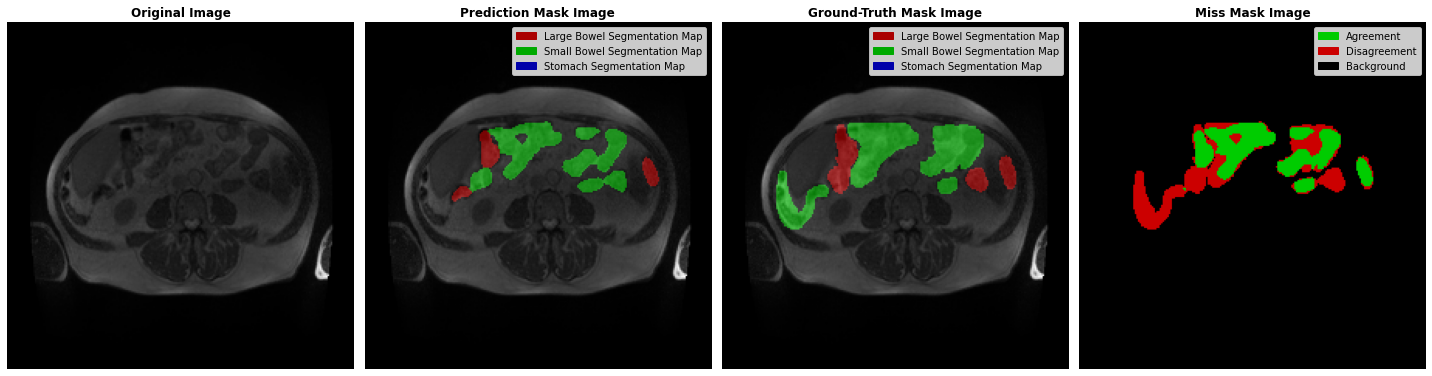

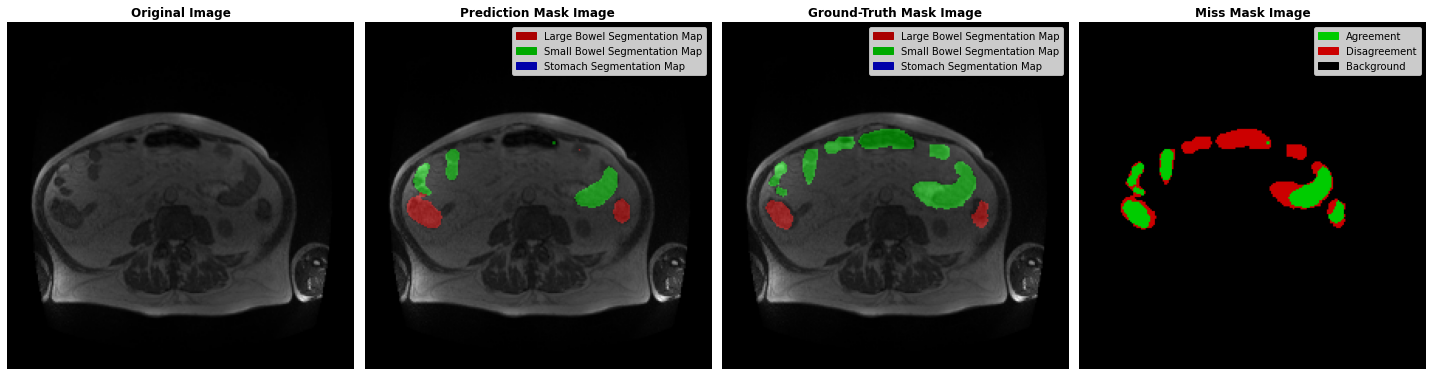

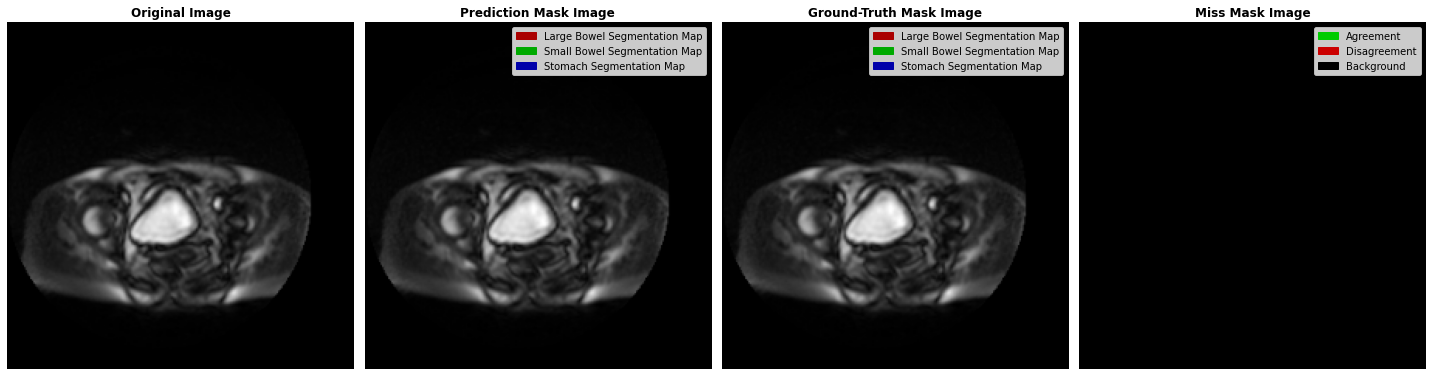

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


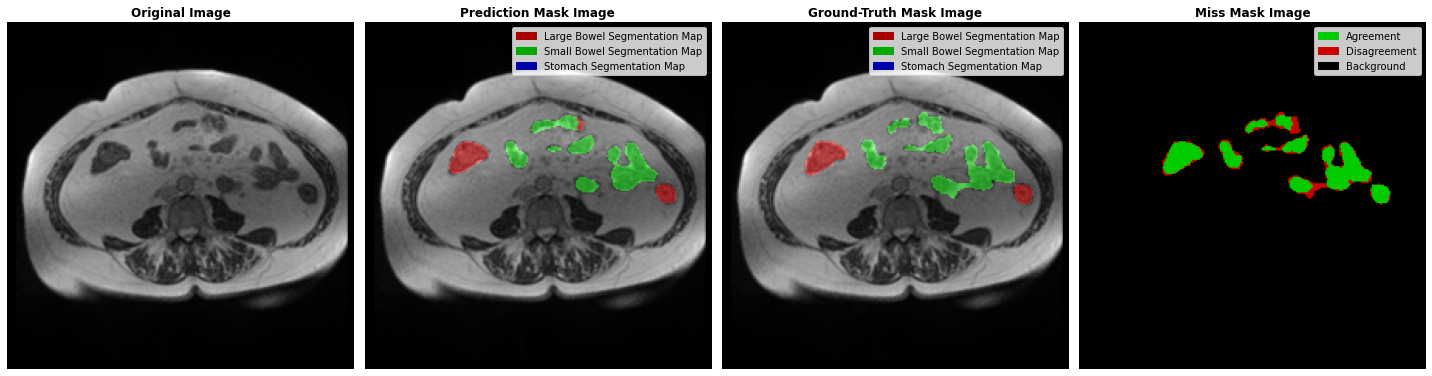

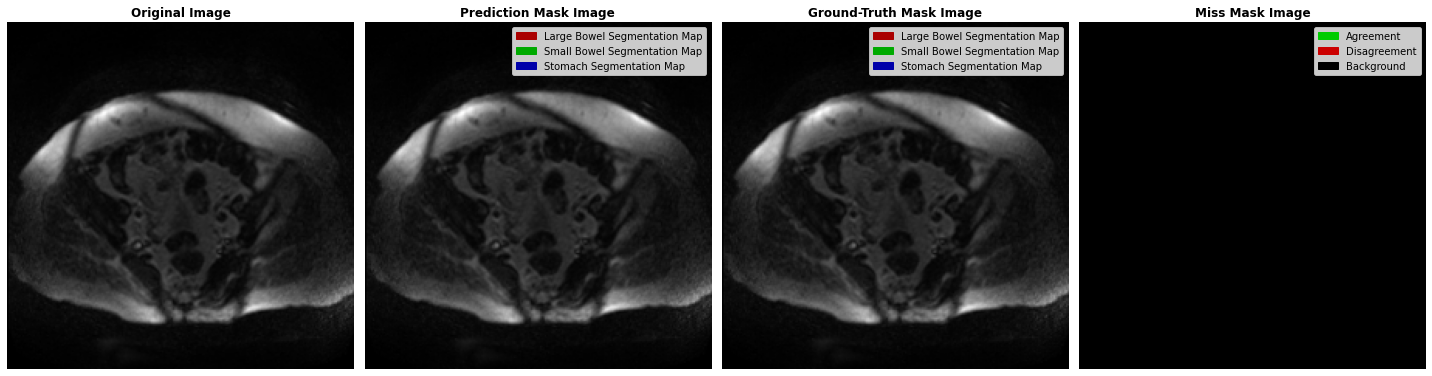

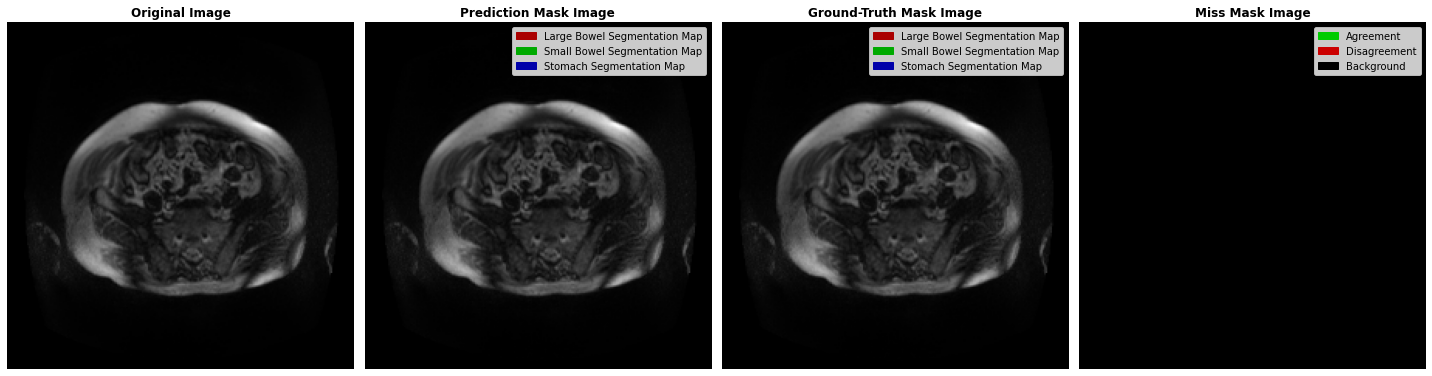

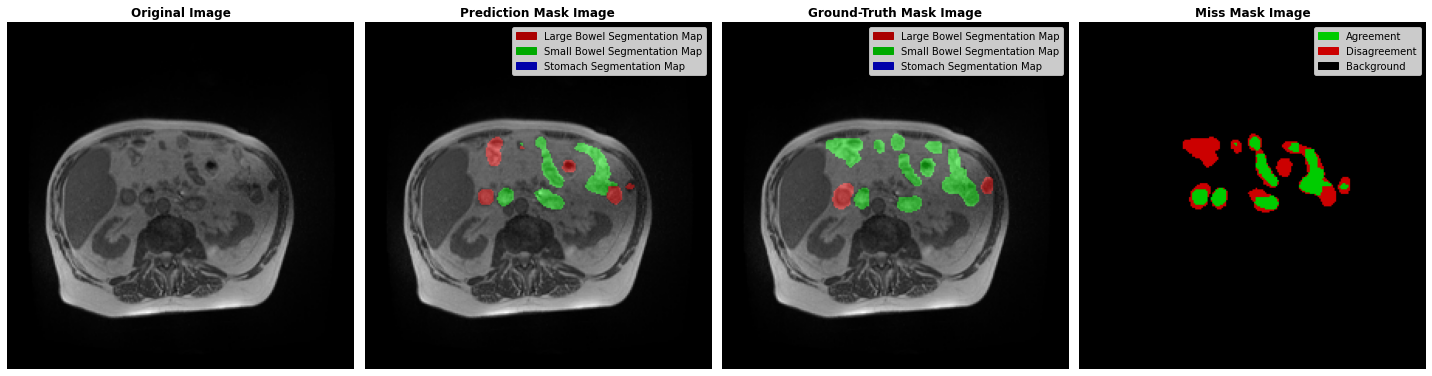

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


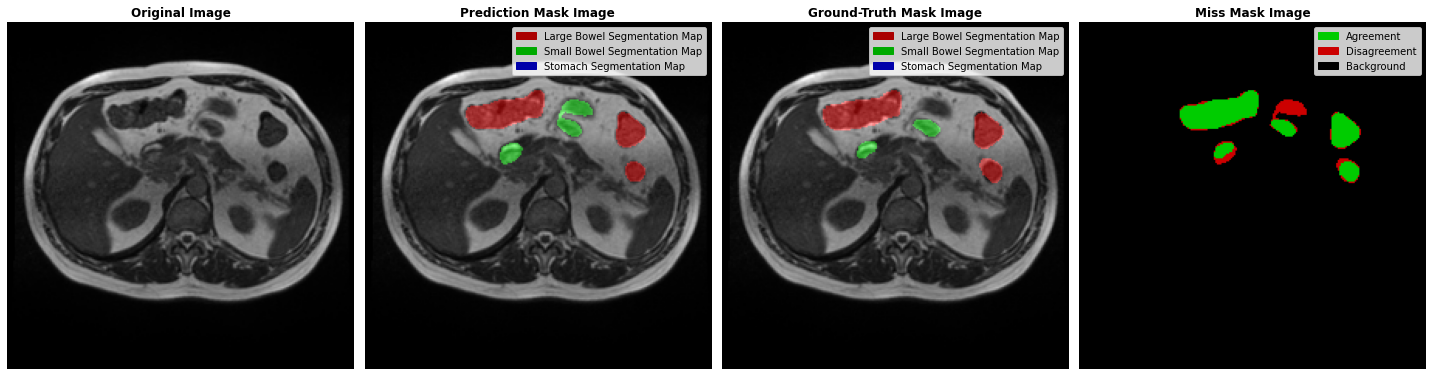

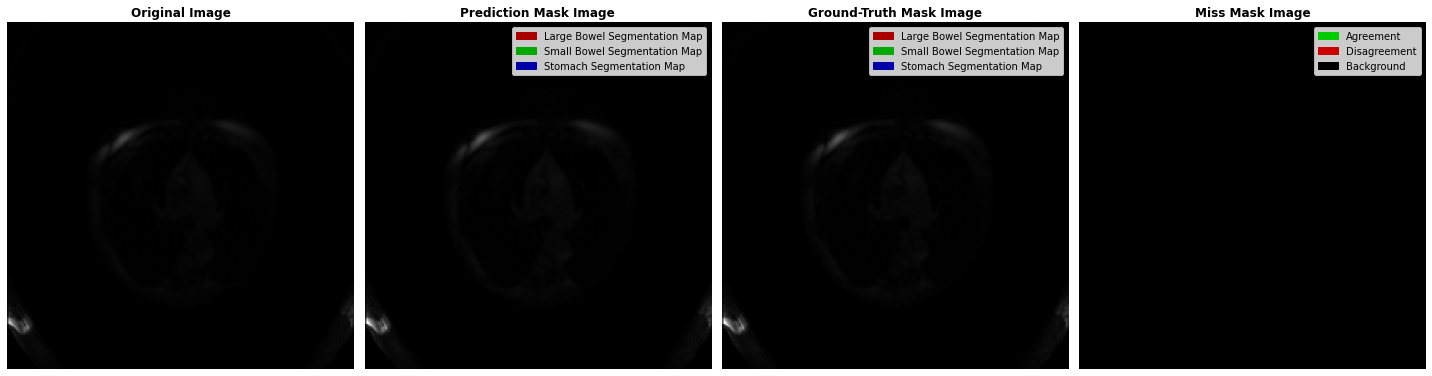

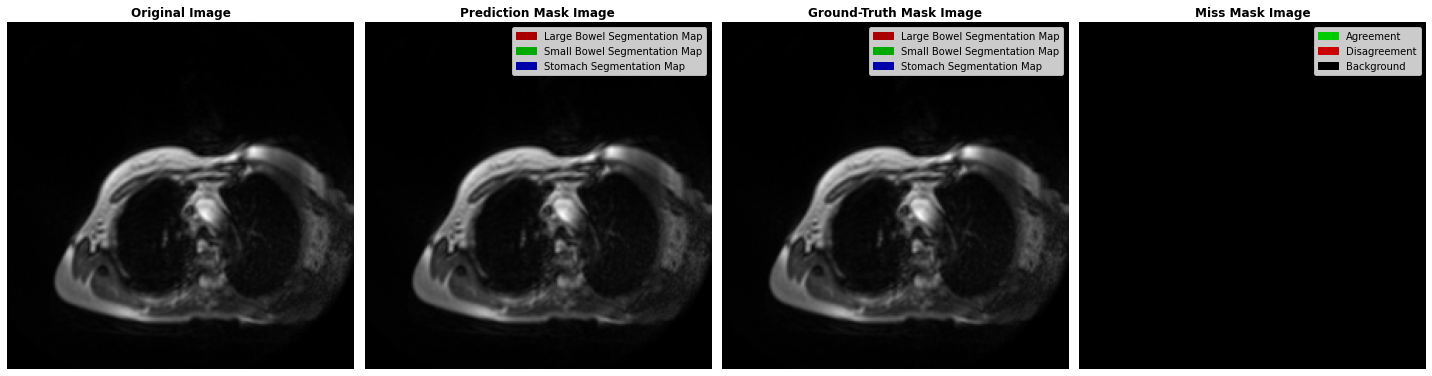

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


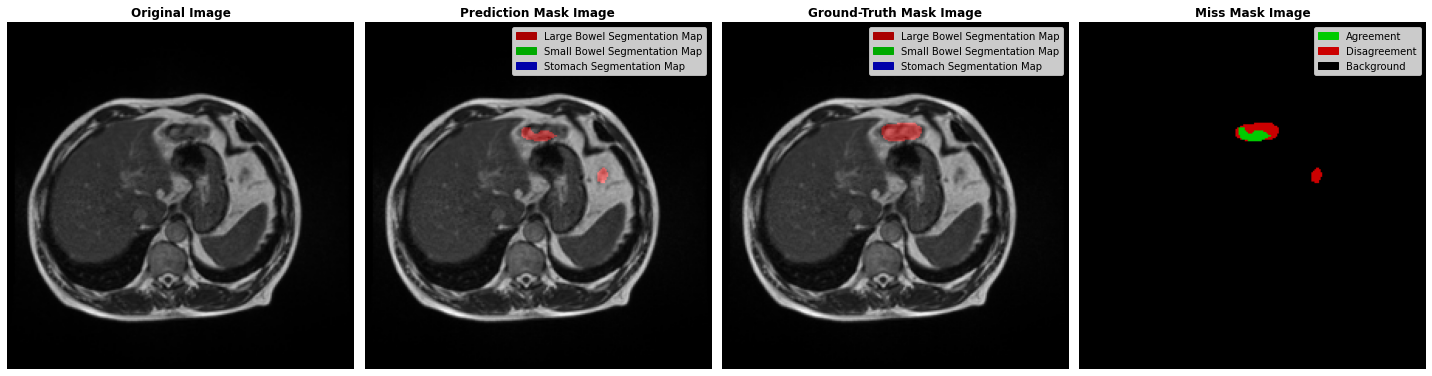

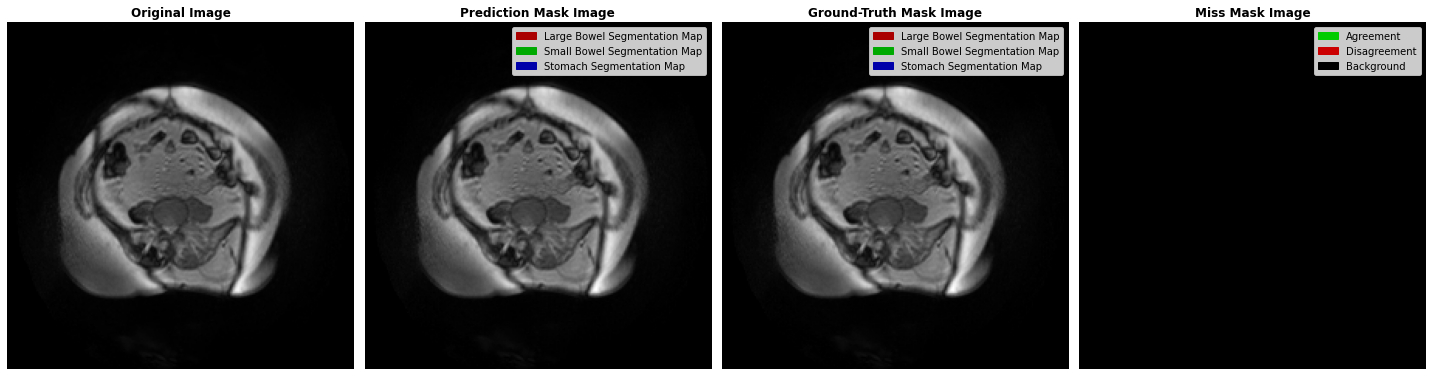

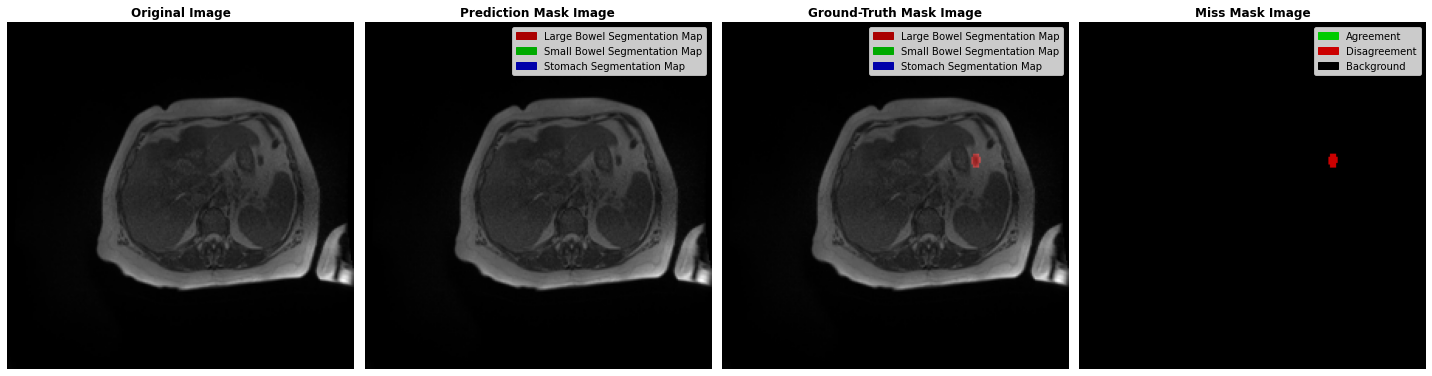

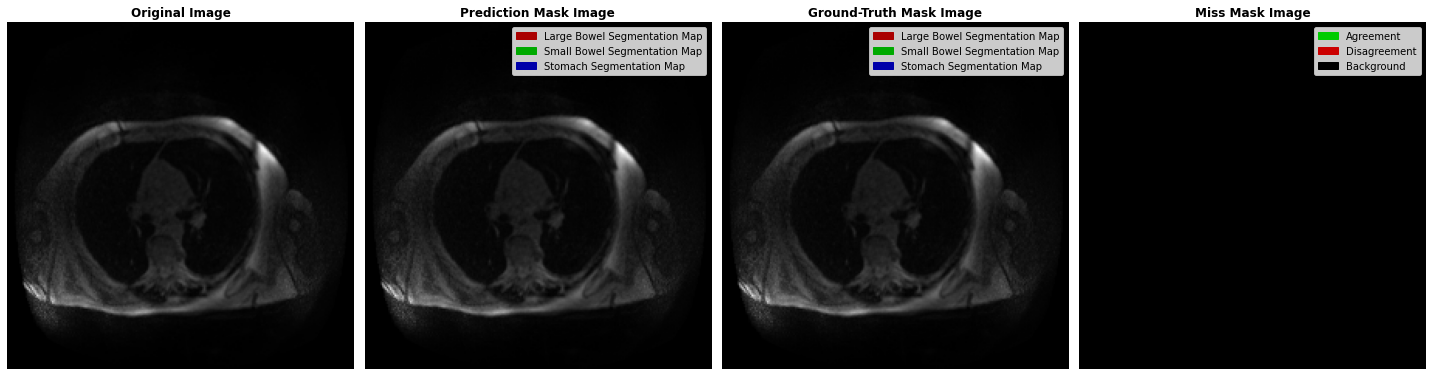

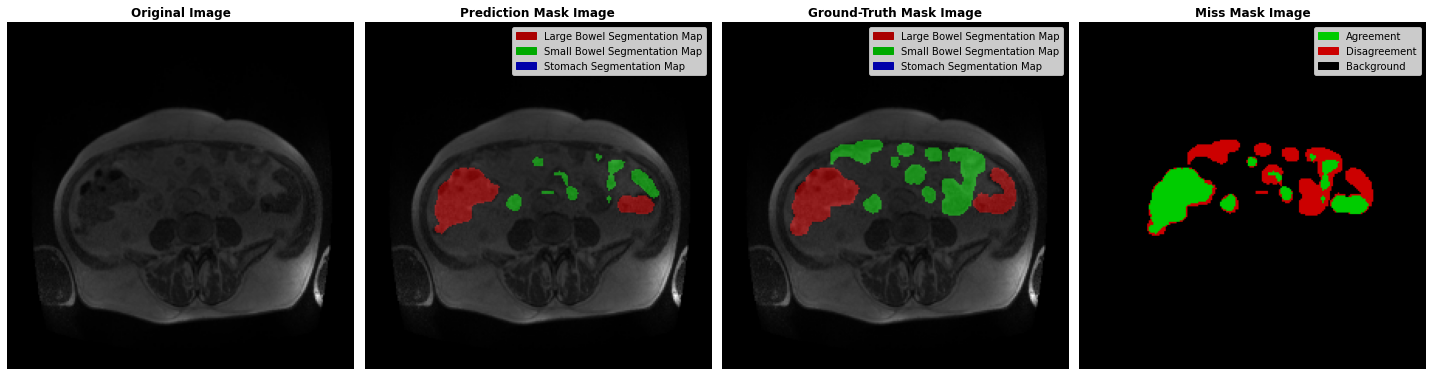

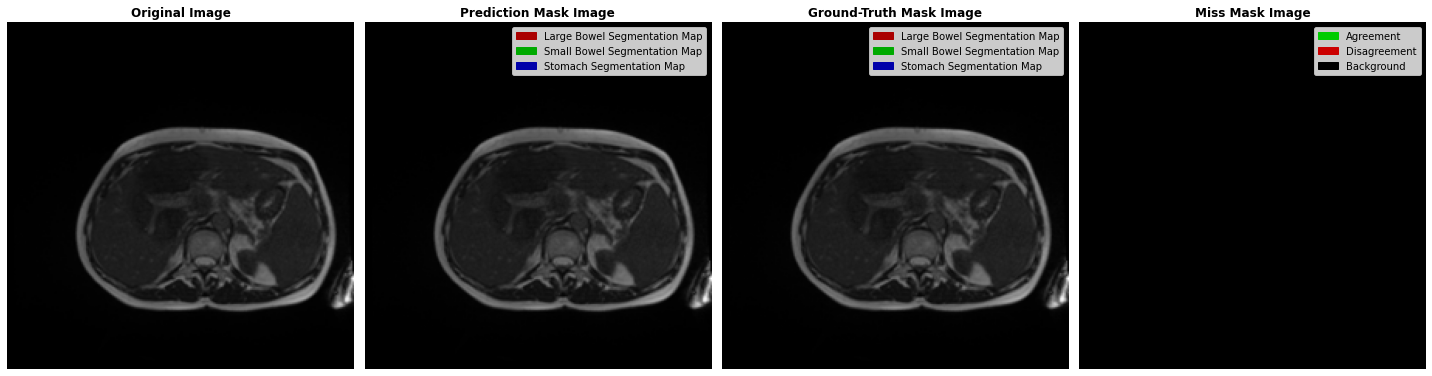

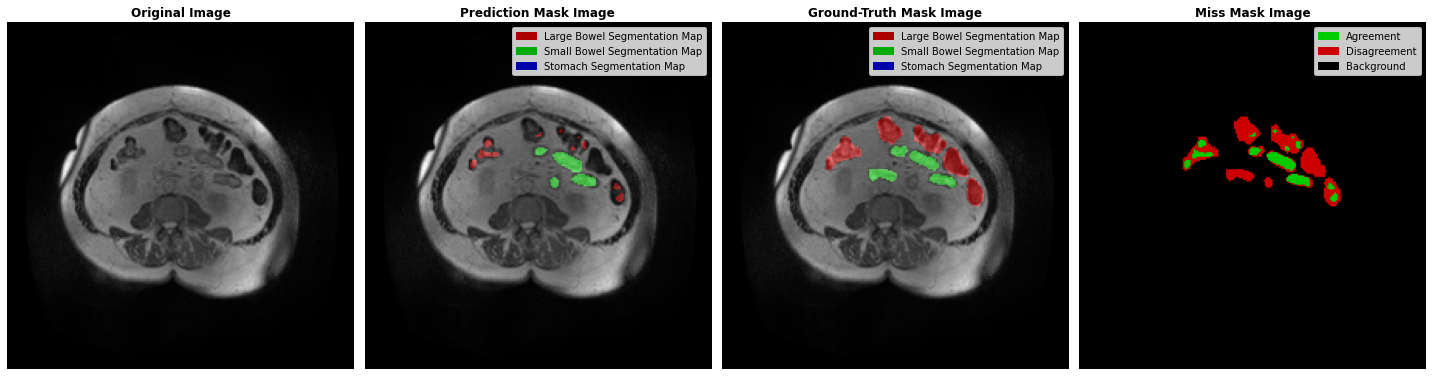

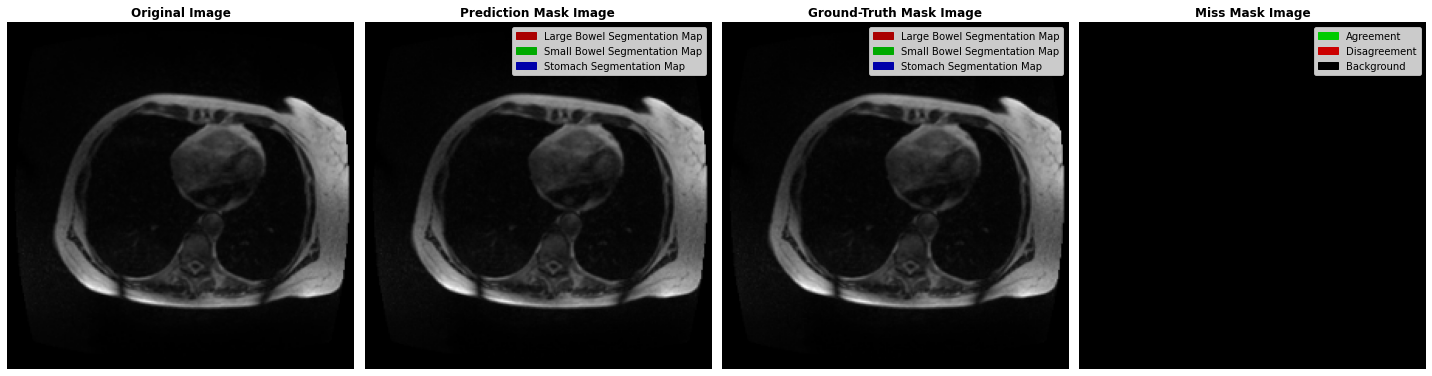

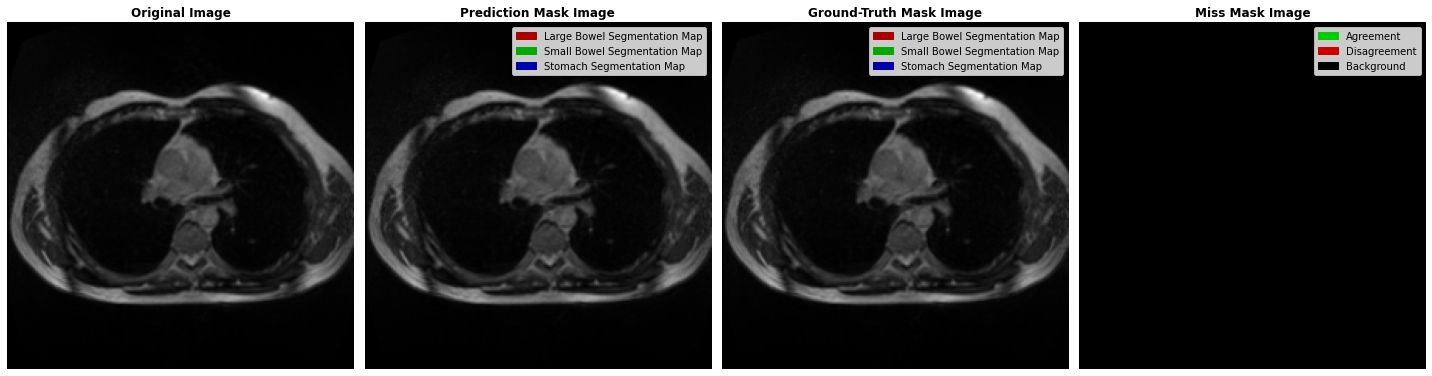

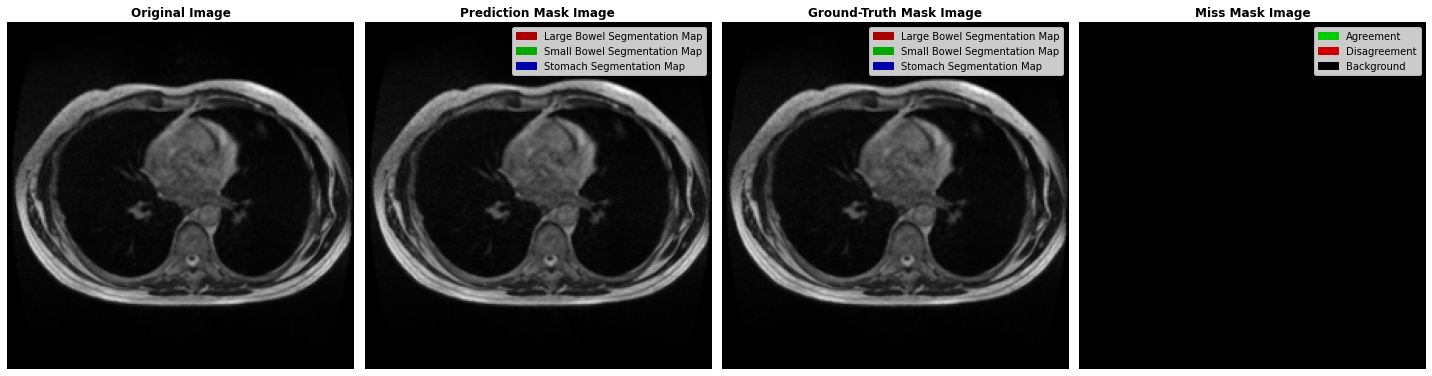

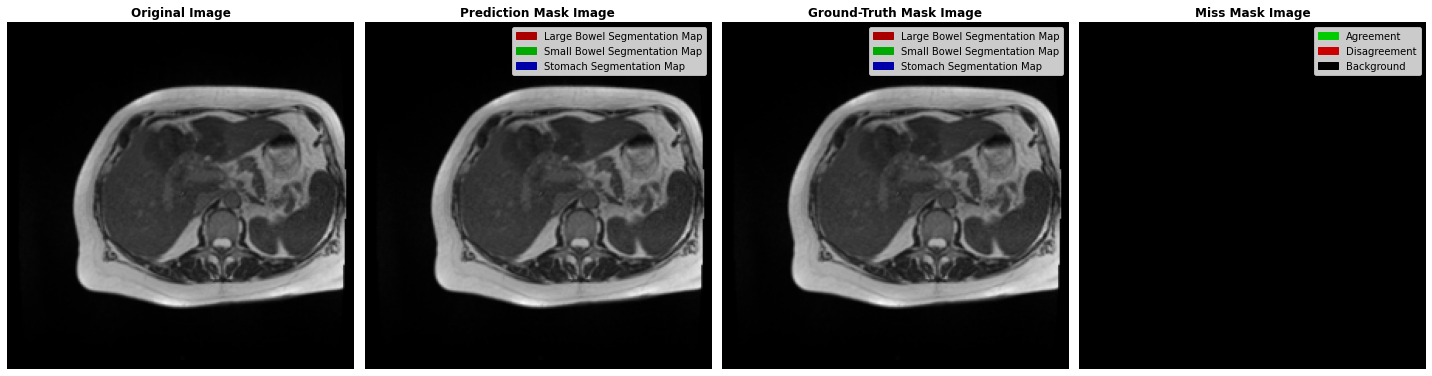

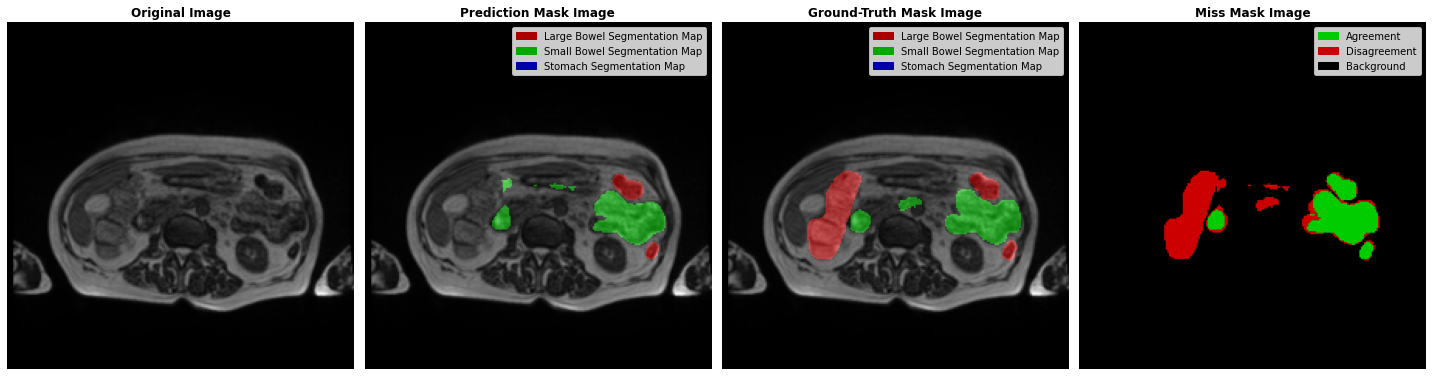

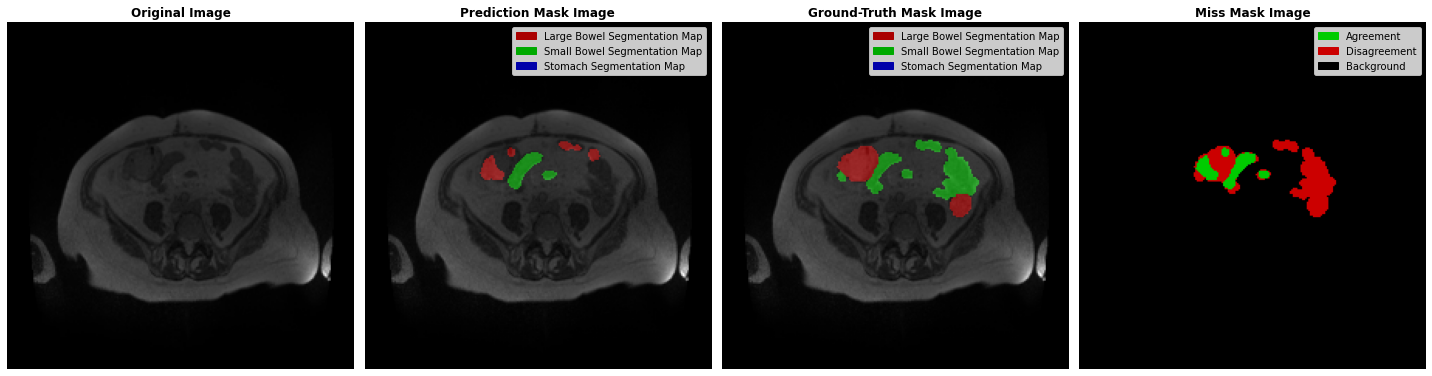

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


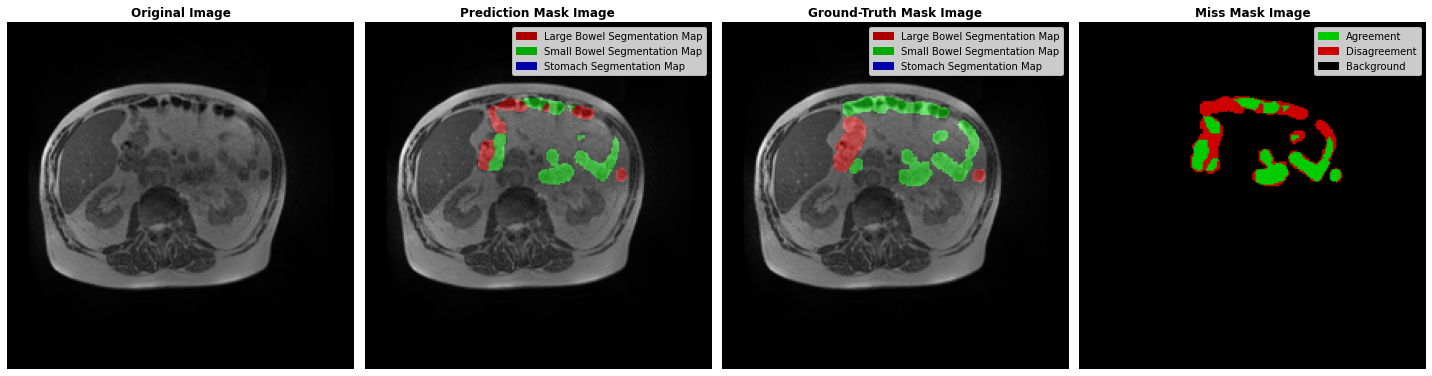

In [19]:
def get_overlay(img, mask, _alpha=0.999, _beta=0.45, _gamma=0):
    
    # Normalize to be between 0-1 (float32)
    img = (img/img.max()).astype(np.float32)
    
    # Make mask RGB and float32
    if len(mask.shape)==2:
        mask_rgb = np.zeros_like(img, dtype=np.float32)
        mask_rgb[..., 2] = np.where(mask==3, 1.0, 0.0)
        mask_rgb[..., 1] = np.where(mask==2, 1.0, 0.0)
        mask_rgb[..., 0] = np.where(mask==1, 1.0, 0.0)
    else:
        mask_rgb=mask.astype(np.float32)
    
    # overlay
    seg_overlay = cv2.addWeighted(src1=img, alpha=_alpha, 
                                  src2=mask_rgb, beta=_beta, gamma=_gamma)
    return seg_overlay

def get_miss_overlay(gt_mask, pred_mask, _alpha=0.9, _beta=0.25, _gamma=0):
    
    # Make mask RGB and float32
    miss_rgb = np.zeros((*pred_mask.shape[:2],3), dtype=np.float32)
    
    if len(pred_mask.shape)==2:
        miss_rgb[..., 1] = np.where((gt_mask==pred_mask)&(gt_mask!=0), 0.8, 0.0)
        miss_rgb[..., 0] = np.where((gt_mask!=pred_mask), 0.8, 0.0)
    else:
        
        miss_rgb = np.where((gt_mask==pred_mask)&(gt_mask!=0.0), (0.0,0.8,0.0), (0.0,0.0,0.0))
        miss_rgb = np.where((gt_mask!=pred_mask), (0.8,0.0,0.0), miss_rgb)
        
    return miss_rgb

def plot_preds(img, pred_mask, gt_mask):
    gt_overlay = get_overlay(img, gt_mask)
    pred_overlay = get_overlay(img, pred_mask)
    miss_overlay = get_miss_overlay(gt_mask, pred_mask)
    
    plt.figure(figsize=(20,12))
    
    for i, (_desc, _img) in enumerate(zip(["Original", "Prediction Mask", "Ground-Truth Mask", "Miss Mask"], [img, pred_overlay, gt_overlay, miss_overlay])):        
        plt.subplot(1,4,i+1)
        plt.imshow(_img)
        plt.title(f"{_desc} Image", fontweight="bold")        
        plt.axis(False)
        
        if i in [1,2]:
            handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
            labels = ["Large Bowel Segmentation Map", "Small Bowel Segmentation Map", "Stomach Segmentation Map"]
            plt.legend(handles,labels)
        elif i==3:
            handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.0,0.8,0.0), (0.8,0.0,0.0), (0.0, 0.0, 0.0)]]
            labels = ["Agreement", "Disagreement", "Background"]
            plt.legend(handles,labels)
    plt.tight_layout()
    plt.show()

if DEBUG:
    for img_batch, mask_batch in val_ds.take(1):
        pred_batch = deeplabv3plus(img_batch)
        if STYLE=="multilabel":
            pred_batch = np.where(tf.nn.sigmoid(pred_batch)>=0.1, 1.0, 0.0)
        else:
            pred_batch = np.argmax(pred_batch, axis=-1)
        
        img_batch = ((img_batch + 1) * 127.5).numpy().astype(np.int32)
        mask_batch = mask_batch.numpy().squeeze().astype(np.float32)
        break
    for _img, _pred, _mask in zip(img_batch, pred_batch, mask_batch):
        plot_preds(_img, _pred, _mask)

In [74]:
def pred_2_rle(pred_arr, root_shape):
    
    # Get correct size pred array based on initial slice size
    pred_arr = cv2.resize(pred_arr, root_shape, interpolation=cv2.INTER_NEAREST)
    
    # Get individual segmentation masks
    lb_mask = np.where(pred_arr==1,1,0)
    sb_mask = np.where(pred_arr==2,1,0)
    st_mask = np.where(pred_arr==3,1,0)
    
    return rle_encode(lb_mask), rle_encode(sb_mask), rle_encode(st_mask)

N_TEST = int(np.ceil((len(ss_df)//3)/BATCH_SIZE))

# Loop over batches and get prediction
for i, img_batch in tqdm(enumerate(test_ds), total=N_TEST):
    
    # Cleanup every so often
    if i%100==0:
        gc.collect(); gc.collect(); tf.keras.backend.clear_session(); gc.collect()    
    
    # Get predictions
    pred_batch = tf.argmax(deeplabv3plus(img_batch, training=False), axis=-1).numpy()
    
    # Loop over prediction and determine submission dataframe index (3*individual-count because of reduced inference size)
    for j, _pred in enumerate(pred_batch):
        df_idx = 3*(i*BATCH_SIZE+j)
        pred_rles = pred_2_rle(_pred, (ss_df.iloc[df_idx]["slice_h"], ss_df.iloc[df_idx]["slice_w"]))
        
        # Loop over rles and assign the correct row of the submission dataframe
        for k, pred_rle in enumerate(pred_rles):
            ss_df.loc[df_idx+k, "predicted"] = pred_rle
            
ss_df = ss_df[["id", "class", "predicted"]]
ss_df.to_csv("submission.csv", index=False)
display(ss_df)

  0%|          | 0/911 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [142]:
import tensorflow as tf
BACKBONE = tf.keras.applications.ResNet50

In [152]:
IMAGE_SHAPE

(224, 224)

In [151]:
BACKBONE(include_top=False, weights=None, input_shape=(*IMAGE_SHAPE, 3)).save("../data/model/renet50_dummy.h5")

In [153]:
_inputs = tf.keras.layers.Input(shape=(*IMAGE_SHAPE, 3))
BACKBONE(weights="imagenet", include_top=False, input_tensor=_inputs).save("../data/model/renet50_infer.h5")


In [154]:
a = BACKBONE(include_top=False, weights=None, input_shape=(*IMAGE_SHAPE, 3))
type(a)

keras.engine.functional.Functional

In [165]:
from tensorflow.keras import models
models.load_model(filepath="../data/model/renet50_infer.h5")

In [73]:
ss_df

id        class predicted  case_id case_id_str  \
0      case123_day20_slice_0001  large_bowel                123     case123   
1      case123_day20_slice_0001  small_bowel                123     case123   
2      case123_day20_slice_0001      stomach                123     case123   
3      case123_day20_slice_0002  large_bowel                123     case123   
4      case123_day20_slice_0002  small_bowel                123     case123   
...                         ...          ...       ...      ...         ...   
65563  case124_day19_slice_0143  small_bowel                124     case124   
65564  case124_day19_slice_0143      stomach                124     case124   
65565  case124_day19_slice_0144  large_bowel                124     case124   
65566  case124_day19_slice_0144  small_bowel                124     case124   
65567  case124_day19_slice_0144      stomach                124     case124   

       day_num day_num_str    slice_id  \
0           20       day20  slice_0001   
1           20       day20  slice_0001   
2           20       day20  slice_0001   
3           20       day20  slice_0002   
4           20       day20  slice_0002   
...        ...         ...         ...   
65563       19       day19  slice_0143   
65564       19       day19  slice_0143   
65565       19       day19  slice_0144   
65566       19       day19  slice_0144   
65567       19       day19  slice_0144   

                                                  f_path  slice_h  slice_w  \
0      ../data\train\case123\case123_day20\scans\slic...      266      266   
1      ../data\train\case123\case123_day20\scans\slic...      266      266   
2      ../data\train\case123\case123_day20\scans\slic...      266      266   
3      ../data\train\case123\case123_day20\scans\slic...      266      266   
4      ../data\train\case123\case123_day20\scans\slic...      266      266   
...                                                  ...      ...      ...   
65563  ../data\train\case124\case124_day19\scans\slic...      266      266   
65564  ../data\train\case124\case124_day19\scans\slic...      266      266   
65565  ../data\train\case124\case124_day19\scans\slic...      266      266   
65566  ../data\train\case124\case124_day19\scans\slic...      266      266   
65567  ../data\train\case124\case124_day19\scans\slic...      266      266   

       px_spacing_h  px_spacing_w  
0               1.5           1.5  
1               1.5           1.5  
2               1.5           1.5  
3               1.5           1.5  
4               1.5           1.5  
...             ...           ...  
65563           1.5           1.5  
65564           1.5           1.5  
65565           1.5           1.5  
65566           1.5           1.5  
65567           1.5           1.5  

[65568 rows x 13 columns]